# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
# Librerías generales
import numpy as np
import pandas as pd

# Librerías de Scikit-learn: modelos, métricas, procesamiento y búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Librerías necesrias para graficar
import matplotlib.pyplot as plt
import seaborn as sns

/home/edu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
#dataset = pd.read_csv("./data/loan_data.csv", comment="#")
dataset = pd.read_csv("https://raw.githubusercontent.com/DiploDatos/IntroduccionAprendizajeAutomatico/master/data/loan_data.csv", comment="#")
features = ['DEROG', 'DELINQ', 'DEBTINC', 'VALUE', 'TARGET'] # Ver respuestas ejercicio 1
dataset = dataset[features]

# Separar features (omitimos la primera columna que es ID) y target
X = dataset.drop(columns="TARGET")
y = dataset["TARGET"]

# Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

---
---

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

---


#### 1. ¿De qué se trata el conjunto de datos?

> ##### Descripción del conjunto de datos HMEQ

El conjunto de datos **HMEQ** recopila información sobre **5,960 préstamos con garantía hipotecaria** otorgados por una institución financiera. Incluye tanto variables financieras como demográficas de los solicitantes, así como el resultado final del préstamo:

- Si fue pagado normalmente, o  
- Si hubo **incumplimiento** (*default* o morosidad grave).

El objetivo principal es desarrollar un **modelo predictivo** que, a partir de los datos de los solicitantes, permita anticipar el riesgo de incumplimiento de un préstamo. Este modelo debe ser:

- **Estadísticamente sólido**
- **Interpretable**  
- En línea con las regulaciones de **igualdad de oportunidades de crédito**

De este modo, se podrán justificar adecuadamente las decisiones de **aprobación o rechazo** de solicitudes de crédito.


**Fuente:** [Kaggle - HMEQ Data](https://www.kaggle.com/datasets/ajay1735/hmeq-data/data)

---

#### 2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?

La variable objetivo es `TARGET` (también llamada `BAD`). Es una variable **binaria** que indica si el préstamo fue reembolsado o no:

- `TARGET = 1`: El solicitante **incumplió** el préstamo o fue **moroso grave**.  
- `TARGET = 0`: El préstamo fue **reembolsado** normalmente.

Este resultado adverso ocurrió en **1189 casos**, lo que representa aproximadamente el **20%** del total.
Por lo tanto, la tarea consiste en construir un modelo que pueda predecir si un solicitante de préstamo es riesgoso (`TARGET = 1`) o no (`TARGET = 0`).

---


### 3. ¿Qué información (atributos) hay disponible para hacer la predicción?

Existen **10 atributos predictivos** disponibles (excluyendo la variable objetivo):

| Atributo   | Descripción                                                        |
|------------|--------------------------------------------------------------------|
| LOAN       | Monto solicitado en el préstamo                                    |
| MORTDUE    | Saldo adeudado de la hipoteca existente                            |
| VALUE      | Valor estimado de la propiedad                                     |
| YOJ        | Años en el empleo actual                                           |
| DEROG      | Número de reportes negativos importantes en el historial crediticio |
| DELINQ     | Número de líneas de crédito morosas                                |
| CLAGE      | Antigüedad de la línea de crédito más antigua (en meses)           |
| NINQ       | Número de líneas de crédito abiertas recientemente                  |
| CLNO       | Número total de líneas de crédito                                  |
| DEBTINC    | Relación deuda-ingresos                                            |

---

### 4. ¿Qué atributos imagina usted que son los más determinantes para la predicción?

Los siguientes atributos podrían ser determinantes:

- **DEROG**: Reportes negativos serios → muy fuerte señal de mal historial crediticio.
- **DELINQ**: Refleja la cantidad de líneas de crédito morosas. Un historial de morosidad puede indicar mayor riesgo crediticio.
- **DEBTINC**: Mide la proporción de deuda en relación con los ingresos. Un ratio elevado sugiere una mayor carga financiera y, por ende, mayor probabilidad de impago.
- **VALUE**: Representa el valor de la propiedad en garantía. Un valor bajo podría significar menor respaldo en caso de incumplimiento.

Estas variables están directamente relacionadas con la solvencia financiera y la estabilidad del solicitante, factores clave en la evaluación del riesgo crediticio.

----

### 5. Exploracion primaria y analisis general del dataset.

#### 🎯 Variables de interés


In [3]:
features = ['DEROG', 'DELINQ', 'DEBTINC', 'VALUE', 'TARGET']
dataset = dataset[features]

#### 🧾 Vista general


In [4]:
print("▶ Forma del dataset:", dataset.shape)
display(dataset.head())


▶ Forma del dataset: (1854, 5)


,DEROG,DELINQ,DEBTINC,VALUE,TARGET
0,0.0,0.0,29.209023,115506.0,0
1,0.0,0.0,31.545694,101208.0,0
2,0.0,0.0,41.210012,79538.0,0
3,1.0,0.0,28.602076,57713.0,0
4,0.0,0.0,30.686106,106084.0,0


#### 🔍 Info y nulos

In [5]:
print("\n▶ Información del dataset:")
dataset.info()

print("\n▶ Valores nulos por columna:")
print(dataset.isna().sum())


▶ Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1854 entries, 0 to 1853
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEROG    1854 non-null   float64
 1   DELINQ   1854 non-null   float64
 2   DEBTINC  1854 non-null   float64
 3   VALUE    1854 non-null   float64
 4   TARGET   1854 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 72.5 KB

▶ Valores nulos por columna:
DEROG      0
DELINQ     0
DEBTINC    0
VALUE      0
TARGET     0
dtype: int64


#### 📊 Resumen estadístico


In [6]:
print("\n▶ Estadísticas descriptivas:")
display(dataset.describe())



▶ Estadísticas descriptivas:


,DEROG,DELINQ,DEBTINC,VALUE,TARGET
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,0.187702,0.319849,34.573408,107321.088457,0.166667
std,0.704882,0.928452,9.308794,56039.685066,0.372779
min,0.000000,0.000000,0.838118,21144.000000,0.000000
25%,0.000000,0.000000,29.427210,70787.250000,0.000000
50%,0.000000,0.000000,35.363407,94198.000000,0.000000
75%,0.000000,0.000000,39.357987,122976.250000,0.000000
max,10.000000,10.000000,144.189001,512650.000000,1.000000


* DEROG y DELINQ:
Sesgadas a 0. Tienen algunos outliers con valores grandes (hasta 10) que podrían tener alto impacto en modelos sensibles a escala.
El min-max es de 0 a 10 cuando la media es 0.187702 y 0.319849.

* DEBTINC:
Distribución más razonable en el centro. Pero el máximo de 144 es muy alto comparado con la media (~34) y el 75% (~39).

* VALUE:
El valor máximo (512,650) es muy alto comparado con la media (~107,000).

* TARGET:
Desbalanceado: solo ~17% de clase positiva o TARGET = 1 y el resto (83.33%) tienen TARGET = 0

#### 📈 Distribución de la variable objetivo


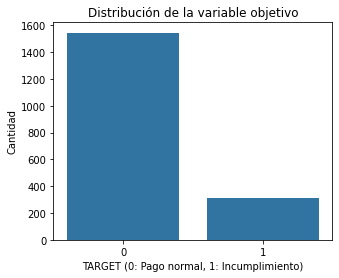


▶ Proporción de clases (TARGET):
TARGET
0    0.833333
1    0.166667
Name: proportion, dtype: float64


In [7]:
plt.figure(figsize=(5,4))
sns.countplot(x='TARGET', data=dataset)
plt.title("Distribución de la variable objetivo")
plt.xlabel("TARGET (0: Pago normal, 1: Incumplimiento)")
plt.ylabel("Cantidad")
plt.show()

print("\n▶ Proporción de clases (TARGET):")
print(dataset['TARGET'].value_counts(normalize=True))


Hay un desbalance que se pudo observar en el cuadro de estadística observado en la celda anterior. Aproximadamente 80% de préstamos fueron pagados (0), 20% incumplidos (1). 

#### Histogramas y Boxplots de variables a analizar


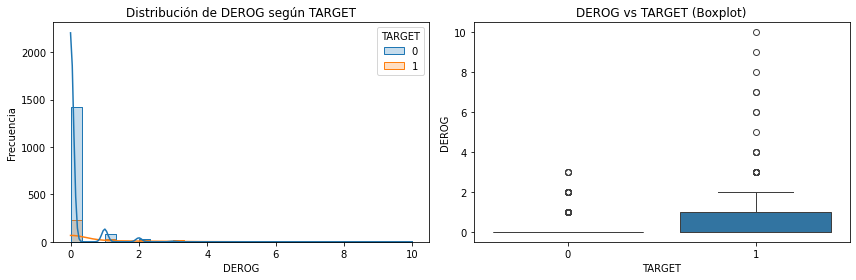

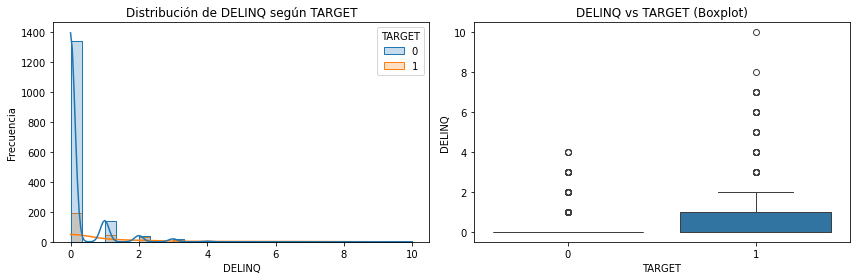

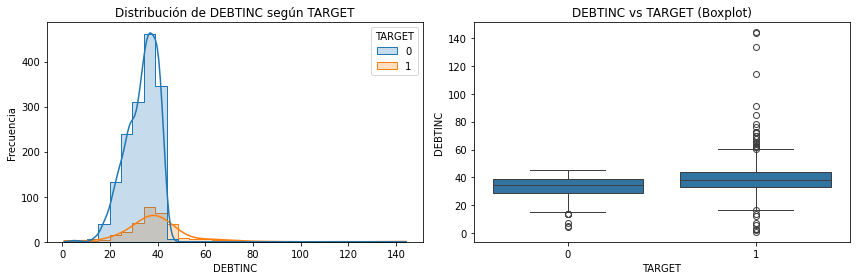

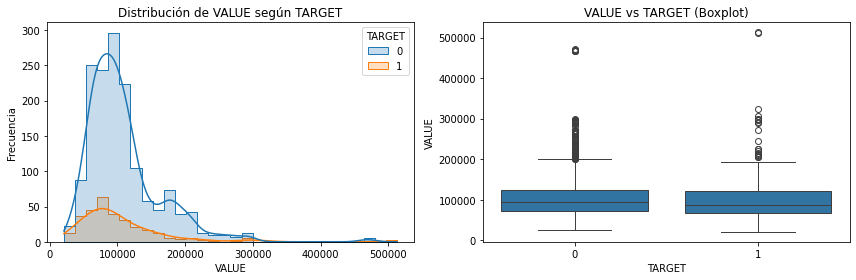

In [8]:
cols = ['DEROG', 'DELINQ', 'DEBTINC', 'VALUE']

for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histograma
    sns.histplot(data=dataset, x=col, hue='TARGET', bins=30, kde=True, element='step', ax=axes[0])
    axes[0].set_title(f"Distribución de {col} según TARGET")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frecuencia")

    # Boxplot
    sns.boxplot(x='TARGET', y=col, data=dataset, ax=axes[1])
    axes[1].set_title(f"{col} vs TARGET (Boxplot)")
    axes[1].set_xlabel("TARGET")
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()


Distribuciones:

* DEROG y DELINQ son variables discretas, con valores concentrados en 0, pero más dispersas en los casos con incumplimiento.
* DEBTINC tiene valores más altos en la clase 1 → sugiere que una mayor relación deuda/ingreso se asocia con mayor probabilidad de incumplimiento.
* VALUE muestra un sesgo positivo (muchos valores bajos, pocos muy altos). No se ve una diferencia muy marcada entre clases, pero sí más dispersión en los incumplimientos.

Boxplots:

* Refuerzan las observaciones anteriores: hay más outliers y valores altos en DEBTINC, DEROG, DELINQ cuando TARGET = 1.

¿Qué valores imputamos y cuales no?

* DEROG (reportes negativos graves)  → Distribución: discreta, mayoría en 0, valores extremos hasta 10. No eliminar outliers porque los valores altos tienen significado real.
* DELINQ (líneas de crédito morosas) → Valores altos también reflejan riesgo real.
* DEBTINC (relación deuda/ingreso)   → hay casos > 100% → sospechosos o extremos. Entonces revisar casos > 60–70%: podrían ser errores o situaciones muy inusuales.
* VALUE (valor de la propiedad)      →  Valor típico: ~90,000–120,000. Máximo: más de 500,000 → puede ser real pero inusual.

#### 🔥 Correlaciones

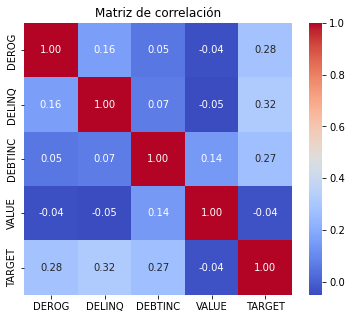

In [9]:
plt.figure(figsize=(6,5))
sns.heatmap(dataset.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

La correlación con TARGET es baja en todos los casos, lo cual es esperable con variables individuales en problemas complejos. 
Pero DEBTINC, DEROG y DELINQ muestran mayor relación que VALUE.

---
---

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

**Definimos algunas funciones que nos serán útiles para visualizar resultados**

In [10]:
# Función para analizar y visualizar predicción de un modelo
def evaluar(model, x_data, y_true, dataset_name):
    """
    Evalúa un modelo de clasificación binaria con sus datos de entrada y, usando las etiquetas correctas,
    determina las métricas de desempeño del modelo.
    También visualiza las métricas y grafica la matriz de confusión
    
    Args:
    ---------------
    model: sklearn.linear_model.SGDClassifier | sklearn.tree.DecisionTreeClassifier
        Modelo de clasificación binaria de sklearn.
    x_data : pandas.Dataframe
        Dataset a ser evaluado.
    dataset_name : str
        Nombre para identificar el dataset.
        
    Returns:
    ---------------
    accuracy, precision, recall, f1-score: float
    """
    y_pred = model.predict(x_data)
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    # Imprimo las metricas
    print(f"--- Evaluación para {dataset_name} ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    # Gráfico
    labels = ['No Incumple (0)', 'Incumple (1)']
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Matriz de Confusión - {dataset_name}')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predicho')
    plt.tight_layout()
    plt.show()
    
    return acc, prec, rec, f1

In [11]:
def graficar_metricas_train_tesst(train_metrics, test_metrics):
    """
    Muestra gráfico de barras de las métricas obtenidas de la evaluación de un modelo
    
    Args:
    ---------------
    train_metrics, test_metrics : list | tuple
        Lista o tupla de float con las métricas obtenidas de la evaluación de un modelo. Los elementos deben
        estar presentes en el siguiente orden: [{accuracy}, {precision}, {recall}, {f1}]
    """
    # Crear dataframe con métricas (excepto la matriz de confusión)
    metricas_keys = ["accuracy", "precision", "recall", "f1"]
    df_metricas = pd.DataFrame({
        "Métrica": metricas_keys,
        "Entrenamiento": train_metrics,
        "Evaluación": test_metrics
    })

    # Configurar índice
    df_metricas.set_index("Métrica", inplace=True)

    # Graficar
    ax = df_metricas.plot(kind="bar", colormap="Set2", figsize=(10, 6), edgecolor="black")
    plt.title("Comparación de métricas: Entrenamiento vs Evaluación (SGDClassifier)")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(title="Conjunto", loc="lower right")
    plt.tight_layout()
    plt.show()

In [12]:
def metrics_vs_umbral(model, x_data, y_true_data):
    """
    grafica evolución de las métricas de desempeño de un clasificador binario de puntaje en función del umbral
    elegido.
    
    Args:
    ---------------
    model : sklearn.linear_model.SGDClassifier | sklearn.tree.DecisionTreeClassifier
        Modelo de clasificación binaria de sklearn.
    x_data : pandas.Dataframe
        Datos de entrada a ser evaluado.
    y_true_data : pandas.DataFrame
        etiquetas de los datos de entrada.
    """
    # Obtener scores del modelo
    y_scores = model.decision_function(x_data)

    # Definir umbrales a probar
    thresholds = np.linspace(y_scores.min(), y_scores.max(), 500)

    # Inicializar listas para métricas
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    # Calcular métricas para cada umbral
    for t in thresholds:
        y_pred_t = (y_scores >= t).astype(int)
        accuracy_list.append(accuracy_score(y_true_data, y_pred_t))
        precision_list.append(precision_score(y_true_data, y_pred_t, zero_division=0))
        recall_list.append(recall_score(y_true_data, y_pred_t, zero_division=0))
        f1_list.append(f1_score(y_true_data, y_pred_t, zero_division=0))

    # Graficar todas las curvas
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracy_list, label='Accuracy')
    plt.plot(thresholds, precision_list, label='Precision')
    plt.plot(thresholds, recall_list, label='Recall')
    plt.plot(thresholds, f1_list, label='F1 Score')
    plt.xlabel('Umbral de decisión')
    plt.ylabel('Valor de la métrica')
    plt.title('Curvas de métricas vs. Umbral de decisión')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
def roc_graph(model, x_data, y_data):
    """
    grafica curva ROC sobre un conjunto de datos.
    
    Args:
    ---------------
    model : sklearn.linear_model.SGDClassifier | sklearn.tree.DecisionTreeClassifier
        Modelo de clasificación binaria de sklearn.
    x_data : pandas.Dataframe
        Datos de entrada a ser evaluado.
    y_data : pandas.DataFrame
        etiquetas de los datos de entrada.
    """
    # Calcular FPR (False Positive Rate), TPR (True Positive Rate)
    y_scores = model.decision_function(x_data)
    fpr, tpr, _ = roc_curve(y_data, y_scores)
    
    # Calcular área bajo la curva ROC
    roc_auc = auc(fpr, tpr)
    
    # Calcular área bajo la curva ROC
    roc_auc = auc(fpr, tpr)

    # Graficar curva ROC
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # línea aleatoria
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - Mejor modelo')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Vemos qué parámetros tiene la clase SGDClassifier y cuáles son sus opciones por defecto**

In [14]:
SGDClassifier??

**Veamos los valores por defecto de SGDClassifier:**

Parámetros:
- **loss**: 'hinge' (loss function)
- **penalty**: 'l2' (penalty -aka regularization term- to be used)
- **alpha**: 0.0001 (constant that multiplies the regularization term)
- **l1_ratio**: 0.15 (elastic Net mixing parameter. Only used when \`penalty\` is 'elasticnet')
- **fit_intercept**: (whether the intercept should be estimated or not)
- **max_iter**: 1000 (maximum number of passes over the training data -aka epochs-)
- **tol**: 1e-3 (stopping criterion. Training will stop when (loss > best_loss - tol) for ``n_iter_no_change`` consecutive epochs)
- **suffle**: True (whether or not the training data should be shuffled after each epoch)
- **epsilon**: 0.1 (epsilon-insensitive loss functions. Only used when \`loss\` is 'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive')
- **n_jobs**: None (number of CPUs to use to do the OVA)
- **learning_rate**: 'optimal' (learning rate schedule)
- **eta0**: 0.0 (initial learning rate. Only used when learning rate is 'constant', 'invscaling' or 'adaptive')
- **power_t**: 0.5 (exponent for inverse scaling learning rate)
- **early_stopping**: False (whether to use early stopping to terminate training when validation score is not improving)
- **validation_fraction**: 0.1 (proportion of training data to set aside as validation set for early stopping. Only used when early_stopping is True)
- **n_iter_no_change**: 5 (number of iterations with no improvement to wait before stopping fitting)
- **class_weight**: None (weights associated with classes)
- **warm_start**: False (wether or not to reuse the solution of the previous call to fit as initialization)
- **average**: False (wether or not to compute the averaged SGD weights across all updates and stores the result. Can be set to begin averaging once the total number of samples seen reaches a int value)

Notar que el modelo que ajusta el objeto SGDClassifier se controla con el parámetro de la función costo 'loss'. Por default, usa un SVM lineal.

--- Evaluación para Datos de Entrenamiento ---
Accuracy:  0.1693
Precision: 0.1693
Recall:    1.0000
F1 Score:  0.2895


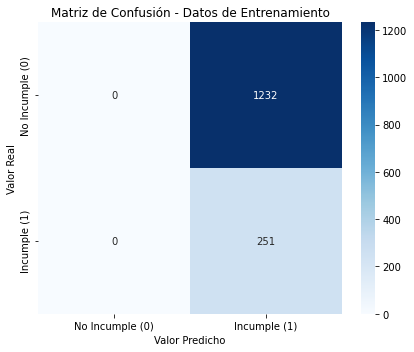

--- Evaluación para Datos de Testeo ---
Accuracy:  0.1563
Precision: 0.1563
Recall:    1.0000
F1 Score:  0.2704


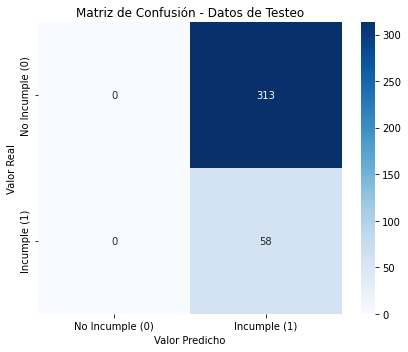

(0.15633423180592992, 0.15633423180592992, 1.0, 0.2703962703962704)

In [15]:
# Entrenar el modelo SGDClassifier con parámetros por defecto y semilla fija
clf = SGDClassifier(random_state=45)
clf.fit(X_train, y_train)

# Evaluamos el modelo en los conjuntos de entrenamiento y testeo y visualizamos los resultados
evaluar(clf, X_train, y_train, "Datos de Entrenamiento")
evaluar(clf, X_test, y_test, "Datos de Testeo")

Vemos que el modelo tiene un muy mal desempeño. Hay dos cosas a tener en cuenta al respecto:

- El dataset está desbalanceado, tenemos muchos más datos etiquetados como $0$ que como $1$. Agregamos entonces class_weight='balanced' al modelo: esto ajusta automáticamente la penalización por clase en función de su frecuencia.

- SGDClassifier es un modelo lineal entrenado por descenso de gradiente, y es muy sensible a las escalas de los atributos.
    * VALUE está en cientos de miles.
    * DEROG y DELINQ van de 0 a 10.
    Es por ello que estandarizamos los datos.

--- Evaluación para Datos de Entrenamiento ---
Accuracy:  0.8146
Precision: 0.4496
Recall:    0.4263
F1 Score:  0.4376


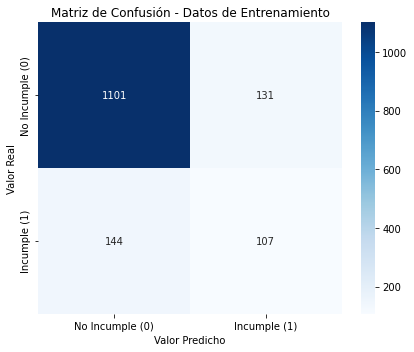

--- Evaluación para Datos de Testeo ---
Accuracy:  0.8302
Precision: 0.4528
Recall:    0.4138
F1 Score:  0.4324


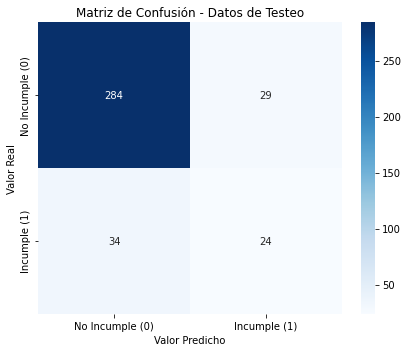

In [16]:
# Genero el pipeline
pipeline_def = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SGDClassifier(random_state=45, class_weight='balanced'))
])

# Entreno
pipeline_def.fit(X_train, y_train)

# Evaluamos el modelo en los conjuntos de entrenamiento y testeo y visualizamos los resultados
acc_train_SG_def, prec_train_SG_def, rec_train_SG_def, f1_train_SG_def = evaluar(pipeline_def, X_train, y_train, "Datos de Entrenamiento")
acc_test_SG_def, prec_test_SG_def, rec_test_SG_def, f1_test_SG_def = evaluar(pipeline_def, X_test, y_test, "Datos de Testeo")

Veamos gráficamente las métricas en cada conjunto:

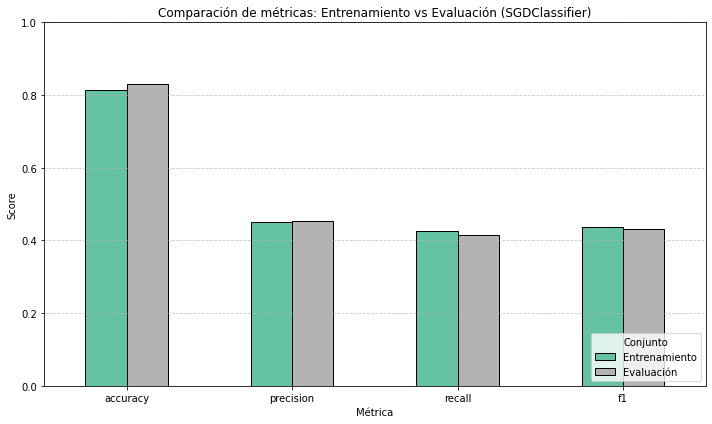

In [17]:
train_metrics_sgd_def = [acc_train_SG_def, prec_train_SG_def, rec_train_SG_def, f1_train_SG_def]
test_metrics_sgd_def = [acc_test_SG_def, prec_test_SG_def, rec_test_SG_def, f1_test_SG_def]
graficar_metricas_train_tesst(train_metrics_sgd_def, test_metrics_sgd_def)

Entrenamiento:

* Accuracy: 0.8146 → el 81,46% de los ejemplos son clasificados correctamente.
* Precision: 0.4496 → de todos los que predijo como 1 (malos), solo el 44.96% realmente lo eran.
* Recall: 0.4263 → el modelo detecta el 42.63% de los verdaderos casos 1.
* F1 Score: 0.4376 → medida armónica entre precision y recall. Bastante baja.

Test:

* Accuracy: 0.8302 → se mantiene cerca del entrenamiento, lo cual es bueno (no hay overfitting).
* Precision: 0.4528 → baja, es decir, tiene muchos falsos positivos.
* Recall: 0.4138 → sigue sin detectar muchos casos de incumplimiento (1).
* F1 Score: 0.4324 → el modelo no es muy bueno detectando morosos.

Interpretación:
* El modelo detecta menos de la mitad de los casos 1 (recall bajo).
* Muchos falsos positivos, lo que baja la precision.
* La performance es consistente entre train y test, lo cual indica que el modelo no está sobreajustado.

Podemos ver cómo varían las métricas en el conjunto de testeo si definimos un umbral para clasificar y lo variamos:

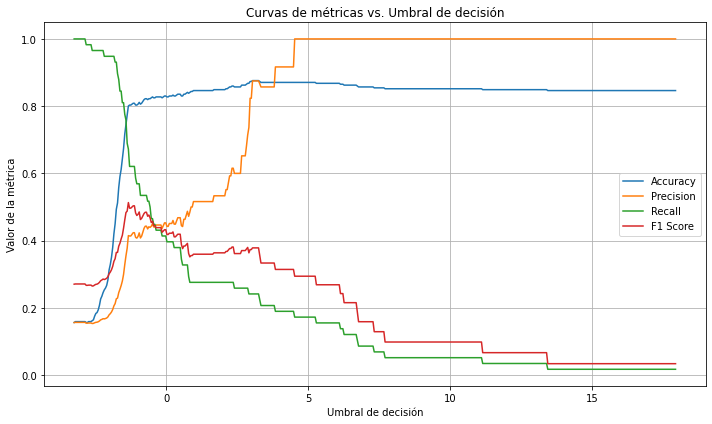

In [18]:
metrics_vs_umbral(pipeline_def, X_test, y_test)

* Si el modelo nunca predice `1`, es porque se observan curvas planas cerca de cero para `precision` y `recall`.
* El pico de `F1` suele ser un buen punto de operación.
* Este análisis es útil cuando se desea ajustar el umbral de clasificación manualmente para priorizar `precision` o `recall`.

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

**Hiperparámetros a explorar**
* `loss`: función de pérdida, ej. `log_loss`, `hinge`, `modified_huber`
* `alpha`: regularización (L2), ej. 1e-4, 1e-3, 1e-2
* `eta0`: tasa de aprendizaje inicial, ej. 0.001, 0.01, 0.1
* `penalty`: tipo de regularización, ej. `l2`, `l1`, `elasticnet`

**Notar que** cambiar la función costo cambia el modelo a utilizar:
* Para  `log_loss`: logistic regression
* Para `hinge`: SVM lineal
* Para `modified_huber`: modelo híbrido entre SVM y regresión logística

In [19]:
# 1. Definir pipeline y búsqueda de hiperparámetros

# Crear un pipeline con:
# - Escalado de datos (StandardScaler)
# - Clasificador lineal SGD (entrenamiento estocástico)
pipeline_opt = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SGDClassifier(random_state=45, class_weight='balanced'))  # pondera clases desbalanceadas
])

# Definir la grilla de hiperparámetros a explorar con grid search
param_grid_sgd = {
    'clf__loss': ['log_loss', 'hinge', 'modified_huber'],  # distintas funciones de pérdida y modelos
    'clf__alpha': [1e-4, 1e-3, 1e-2],                      # regularización
    'clf__eta0': [0.001, 0.01, 0.1, 1.0, 0.0],             # tasa de aprendizaje inicial -sólo para learning_rate = 'constant'-
    'clf__penalty': ['l2', 'l1', 'elasticnet'],            # tipo de penalización
    'clf__learning_rate': ['constant', 'optimal']          # usar tasa fija
}

# Configurar búsqueda en grilla con validación cruzada (5 folds)
grid_sgd = GridSearchCV(
    estimator=pipeline_opt,
    param_grid=param_grid_sgd,
    scoring='accuracy',  # métrica de evaluación
    cv=5,                # validación cruzada 5-fold
    n_jobs=-1,           # usar todos los núcleos disponibles
    return_train_score=True
)

# Ejecutar el grid search sobre el conjunto de entrenamiento
grid_sgd.fit(X_train, y_train)

/home/edu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
135 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/home/edu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/edu/.local/lib/python3.10/site-packages/sklearn/base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/edu/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 661, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])

,estimator,Pipeline(step...m_state=45))])
,param_grid,"{'clf__alpha': [0.0001, 0.001, ...], 'clf__eta0': [0.001, 0.01, ...], 'clf__learning_rate': ['constant', 'optimal'], 'clf__loss': ['log_loss', 'hinge', ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


In [20]:
# 2. Mostrar los mejores resultados encontrados

# Convertir resultados en DataFrame para visualización
results_sgd = pd.DataFrame(grid_sgd.cv_results_)

# Mostrar los 10 mejores modelos según accuracy promedio
resumen_sgd = results_sgd[['params', 'mean_test_score', 'std_test_score']]
print("\n--- Top 10 configuraciones ---")
res_sgd_10_mejores = resumen_sgd.sort_values(by='mean_test_score', ascending=False).head(10)

for index, row in res_sgd_10_mejores.iterrows():
    print("Parámetros:")
    print(row['params'])  # Acceder a la columna 'params' de cada fila
    print(f"Accuracy promedio: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})\n")


--- Top 10 configuraciones ---
Parámetros:
{'clf__alpha': 0.0001, 'clf__eta0': 0.01, 'clf__learning_rate': 'constant', 'clf__loss': 'hinge', 'clf__penalty': 'l1'}
Accuracy promedio: 0.8260 (±0.0219)

Parámetros:
{'clf__alpha': 0.01, 'clf__eta0': 0.01, 'clf__learning_rate': 'constant', 'clf__loss': 'hinge', 'clf__penalty': 'l2'}
Accuracy promedio: 0.8200 (±0.0287)

Parámetros:
{'clf__alpha': 0.01, 'clf__eta0': 0.001, 'clf__learning_rate': 'optimal', 'clf__loss': 'hinge', 'clf__penalty': 'l2'}
Accuracy promedio: 0.8193 (±0.0157)

Parámetros:
{'clf__alpha': 0.01, 'clf__eta0': 0.1, 'clf__learning_rate': 'optimal', 'clf__loss': 'hinge', 'clf__penalty': 'l2'}
Accuracy promedio: 0.8193 (±0.0157)

Parámetros:
{'clf__alpha': 0.01, 'clf__eta0': 0.01, 'clf__learning_rate': 'optimal', 'clf__loss': 'hinge', 'clf__penalty': 'l2'}
Accuracy promedio: 0.8193 (±0.0157)

Parámetros:
{'clf__alpha': 0.01, 'clf__eta0': 1.0, 'clf__learning_rate': 'optimal', 'clf__loss': 'hinge', 'clf__penalty': 'l2'}
Accura

In [21]:
# En forma más compacta:

print("\n--- Top 10 configuraciones ---")
print(res_sgd_10_mejores)


--- Top 10 configuraciones ---
                                                params  mean_test_score  \
22   {'clf__alpha': 0.0001, 'clf__eta0': 0.01, 'clf...         0.826049   
201  {'clf__alpha': 0.01, 'clf__eta0': 0.01, 'clf__...         0.819961   
192  {'clf__alpha': 0.01, 'clf__eta0': 0.001, 'clf_...         0.819292   
228  {'clf__alpha': 0.01, 'clf__eta0': 0.1, 'clf__l...         0.819292   
210  {'clf__alpha': 0.01, 'clf__eta0': 0.01, 'clf__...         0.819292   
246  {'clf__alpha': 0.01, 'clf__eta0': 1.0, 'clf__l...         0.819292   
264  {'clf__alpha': 0.01, 'clf__eta0': 0.0, 'clf__l...         0.819292   
183  {'clf__alpha': 0.01, 'clf__eta0': 0.001, 'clf_...         0.819290   
185  {'clf__alpha': 0.01, 'clf__eta0': 0.001, 'clf_...         0.818614   
266  {'clf__alpha': 0.01, 'clf__eta0': 0.0, 'clf__l...         0.817947   

     std_test_score  
22         0.021940  
201        0.028730  
192        0.015681  
228        0.015681  
210        0.015681  
246       

--- Evaluación para Entrenamiento (mejor modelo) ---
Accuracy:  0.8146
Precision: 0.4586
Recall:    0.5299
F1 Score:  0.4917


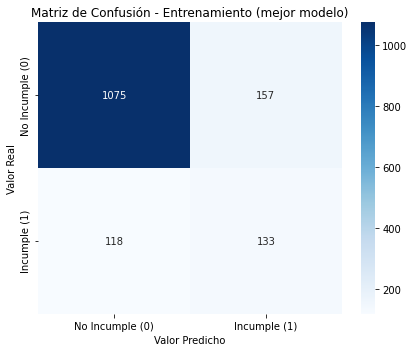

--- Evaluación para Evaluación (mejor modelo) ---
Accuracy:  0.8302
Precision: 0.4603
Recall:    0.5000
F1 Score:  0.4793


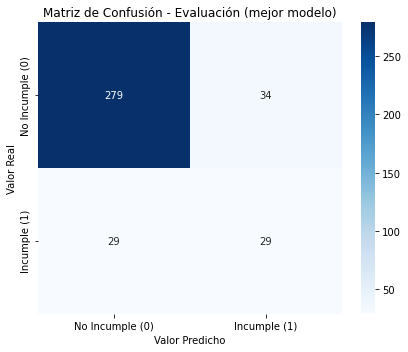

In [22]:
# 3. Evaluar el mejor modelo encontrado

# Extraer el mejor pipeline ajustado
best_model_sgd = grid_sgd.best_estimator_

# Evaluar modelo en ambos conjuntos
acc_train_sgd, prec_train_sgd, rec_train_sgd, f1_train_sgd = evaluar(best_model_sgd, X_train, y_train, "Entrenamiento (mejor modelo)")
acc_test_sgd, prec_test_sgd, rec_test_sgd, f1_test_sgd = evaluar(best_model_sgd, X_test, y_test, "Evaluación (mejor modelo)")

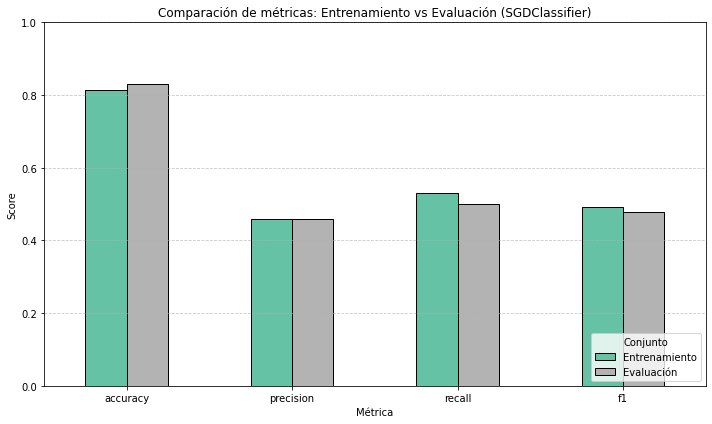

In [23]:
train_metrics_sgd = [acc_train_sgd, prec_train_sgd, rec_train_sgd, f1_train_sgd]
test_metrics_sgd = [acc_test_sgd, prec_test_sgd, rec_test_sgd, f1_test_sgd]
graficar_metricas_train_tesst(train_metrics_sgd, test_metrics_sgd)

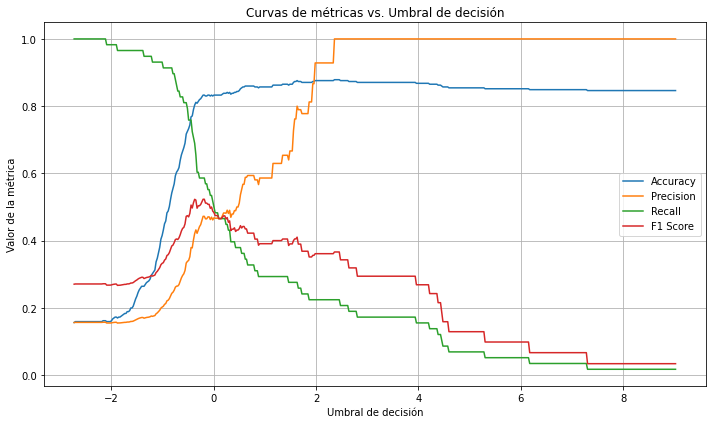

In [24]:
# 4. Curvas de métricas en función del umbral de decisión

metrics_vs_umbral(best_model_sgd, X_test, y_test)

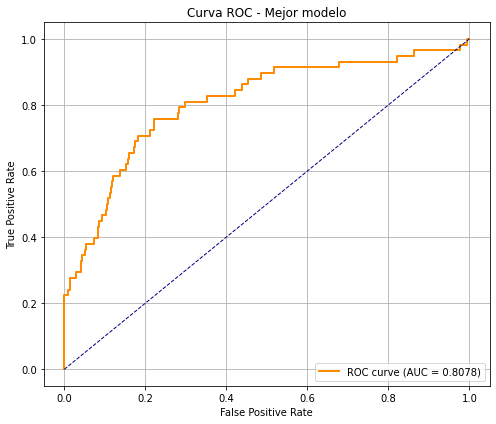

In [25]:
# 5. Curva ROC y cálculo del AUC (área bajo la curva)

roc_graph(best_model_sgd, X_test, y_test)

### 🧠 Conclusión del Ejercicio 2.2 – Comparación antes y después del ajuste de hiperparámetros
Tras aplicar **GridSearchCV** para ajustar los hiperparámetros de `SGDClassifier`, se observaron mejoras consistentes tanto en el conjunto de entrenamiento como en el de evaluación:

#### 📊 Mejora en métricas de evaluación (conjunto de testeo):
| Métrica   |  Antes del ajuste | Después del ajuste |
|-----------|-------------------|--------------------|
| Accuracy  |  0.8302           | 0.8302              |
| Precision |  0.4528           | 0.4603              |
| Recall    |  0.4138           | 0.5000              |
| F1 Score  |  0.4324           | 0.4793              |

Estas mejoras son **particularmente notables en las métricas de Recall y F1 Score**, que son claves en problemas con clases desbalanceadas como este, donde el objetivo principal es detectar correctamente a los incumplidores (`TARGET = 1`).

#### 🧩 Análisis de matrices de confusión:
- **Antes del ajuste**, el modelo identificaba correctamente solo 24 positivos en test, con 34 falsos negativos.
- **Después del ajuste**, el modelo acierta 29 positivos y reduce los falsos negativos a 29.

Esto indica una **mejor capacidad de detección de la clase minoritaria (positiva)**, sin sacrificar significativamente el desempeño en la clase mayoritaria.

---

### ✅ Conclusión final

El ajuste de hiperparámetros permitió encontrar una combinación más eficaz de función de pérdida, tasa de aprendizaje y regularización, mejorando la **generalización del modelo** y su **capacidad para detectar casos relevantes en escenarios desbalanceados**.

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Definimos algunas funciones útiles:

In [26]:
def visualizar_arbol_de_decision(tree_model, max_depth=5):
    """
    Función para visualizar árbol de decisión.
    
    Args:
    ---------------
    tree_model : sklearn.tree.DecisionTreeClassifier
        árbol de decisión a visualizar
    max_depth : int, default == 5
        Profundidad máxima a visualizar
    """
    plt.figure(figsize=(20, 10))
    plot_tree(tree_model,
              feature_names=X.columns,
              class_names=['No Incumple', 'Incumple'],
              filled=True,
              rounded=True,
              max_depth=max_depth,
              fontsize=10)
    plt.title("Árbol de Decisión (hasta profundidad 3)")
    plt.tight_layout()
    plt.show()

In [27]:
def visualizar_variables_importantes(x_data, tree_model, n=4):
    """
    Visualiza las n variables más importantes en el árbol de decisión
    
    Args:
    ---------------
    x_data : pandas.DataFrame
        Datos de entrada
    tree_model : sklearn.tree.DecisionTreeClassifier
        árbol de decisión a visualizar
    n : int, default == 15
        Número de variables a visualizar
    """
    importancias = tree_model.feature_importances_

    # Crear DataFrame ordenado por importancia
    importancia_df = pd.DataFrame({
        'Variable': x_data.columns,
        'Importancia': importancias
    }).sort_values(by='Importancia', ascending=False)

    # Mostrar gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importancia', y='Variable', data=importancia_df.head(n))
    plt.title(f'Top {n} variables más importantes en el Árbol')
    plt.xlabel('Importancia')
    plt.ylabel('Variable')
    plt.tight_layout()
    plt.show()

Veamos las opciones por default de DecisionTreeClassifier

In [28]:
DecisionTreeClassifier??

**Veamos los valores por defecto de DecisionTreeClassifier:**

Parámetros:
- **criterion**: 'gini (function to measure the quality of a split)
- **splitter**: best (strategy used to choose the split at each node)
- **max_depth**: None (maximum depth of the tree)
- **min_samples_split**: 2 (minimum number of samples required to split an internal node)
- **min_samples_leaf**: 1 (minimum number of samples required to be at a leaf node)
- **min_weight**: 0.0 (minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node)
- **max_features**: None (number of features to consider when looking for the best split)
- **max_leaf_nodes**: None (maximum leaf nodes of the tree -grown in best-first fashion-)
- **min_impurity_decrease**: 0.0 (threshold for splitting a node, where a split will occur only if it reduces impurity by an amount greater than or equal to this value)
- **class_weight**: None (weights associated with classes)
- **ccp_alpha**: 0.0 (complexity parameter used for Minimal Cost-Complexity Pruning)
- **monotonic_cst**: None (monotonic relationships between specific features and the predicted output)

--- Evaluación para Entrenamiento ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000


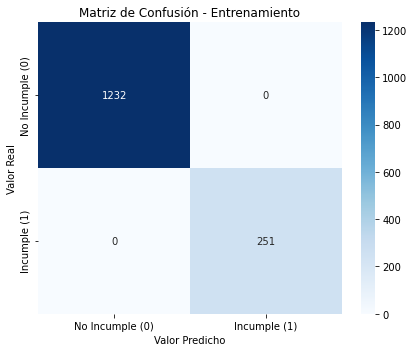

--- Evaluación para Evaluación ---
Accuracy:  0.8356
Precision: 0.4769
Recall:    0.5345
F1 Score:  0.5041


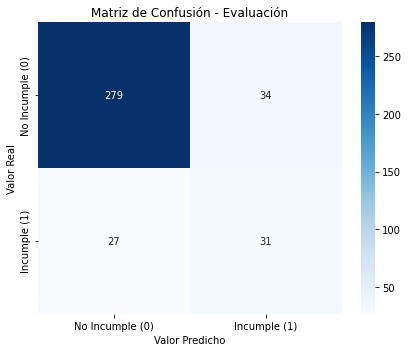

In [29]:
# Instancio un árbol de decisión y lo entreno
clf_arbol_def = DecisionTreeClassifier(random_state=45)
clf_arbol_def.fit(X_train, y_train)

# Visualizo rendimiento
acc_train_arbol_def, prec_train_arbol_def, rec_train_arbol_def, f1_train_arbol_def = evaluar(clf_arbol_def, X_train, y_train, "Entrenamiento")
acc_test_arbol_def, prec_test_arbol_def, rec_test_arbol_def, f1_test_arbol_def = evaluar(clf_arbol_def, X_test, y_test, "Evaluación")

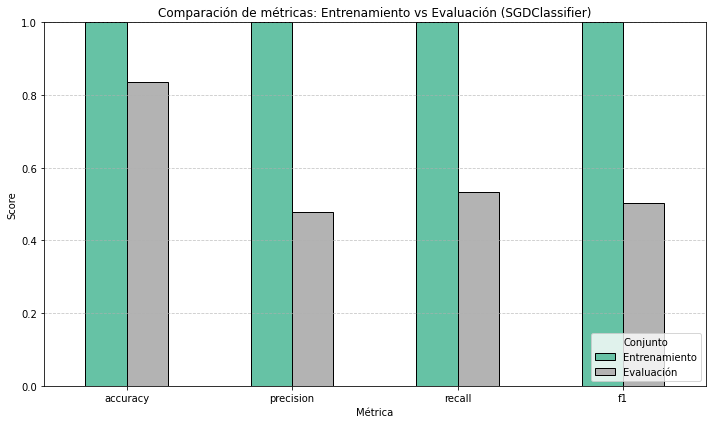

In [30]:
train_metrics_arbol_def = [acc_train_arbol_def, prec_train_arbol_def, rec_train_arbol_def, f1_train_arbol_def]
test_metrics_arbol_def = [acc_test_arbol_def, prec_test_arbol_def, rec_test_arbol_def, f1_test_arbol_def]
graficar_metricas_train_tesst(train_metrics_arbol_def, test_metrics_arbol_def)

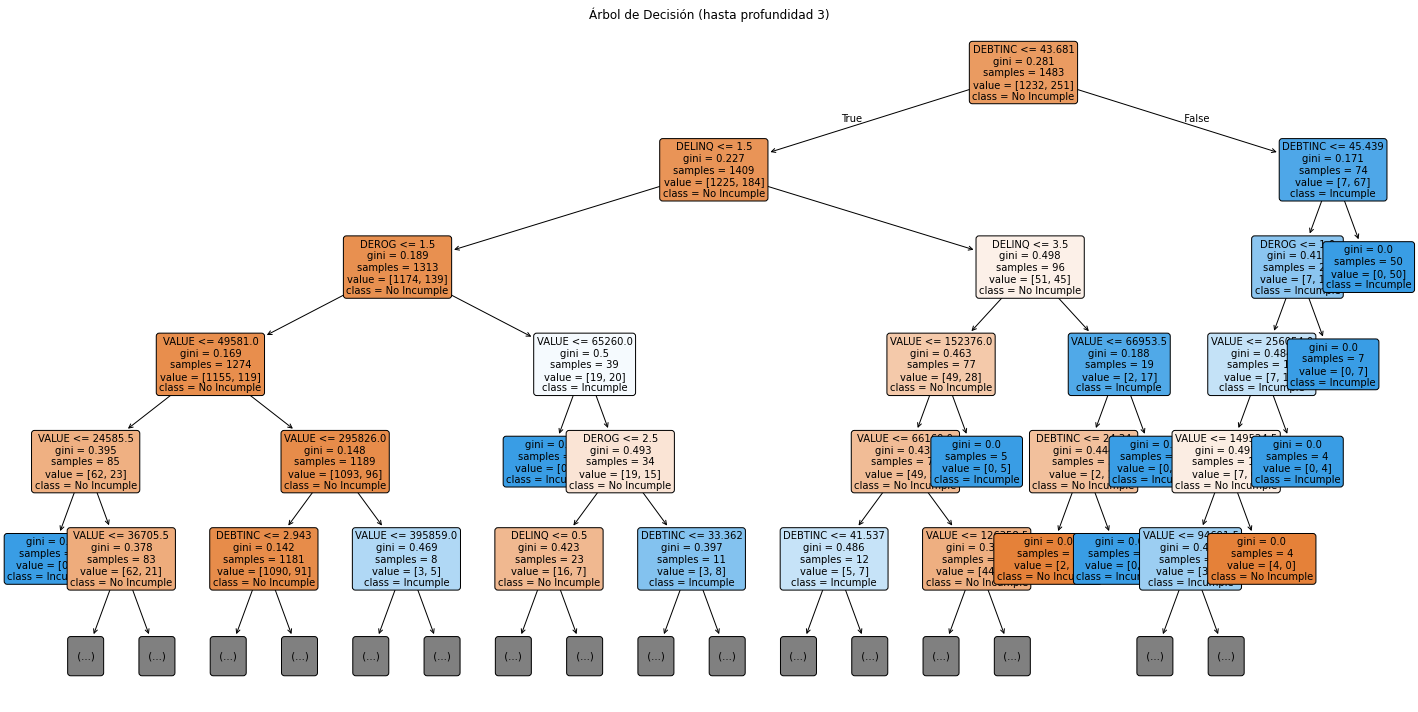

In [31]:
# Mostrar el árbol de decisión
visualizar_arbol_de_decision(clf_arbol_def)

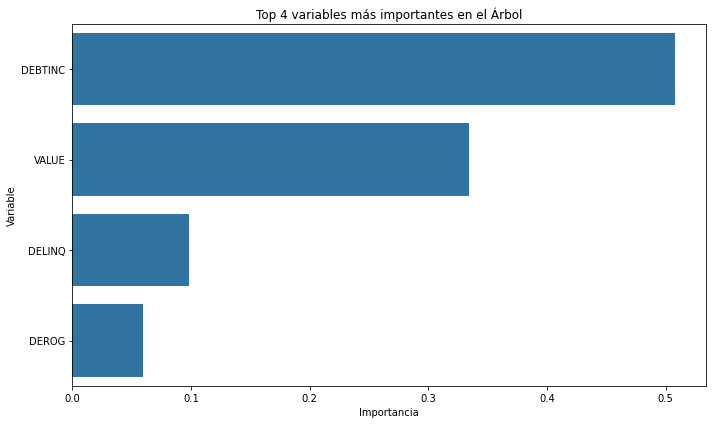

In [32]:
# Veamos la importancia de las variables predictoras

visualizar_variables_importantes(X, clf_arbol_def)

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Debemos probar distintas configuraciones de los siguientes hiperparámetros del `DecisionTreeClassifier`:
* `criterion`: función de impureza (gini, entropy, log_loss)
* `max_depth`: profundidad máxima del árbol (ej.: 3, 5, 10, None)
* `min_samples_leaf`: mínimo de muestras en una hoja

In [33]:
# 1. Definir grilla de hiperparámetros a probar

param_grid_tree = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 4, 6],
}

# 2 GridSearchCV con validación cruzada
grid_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=45),
    param_grid=param_grid_tree,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

# Entrenar
grid_tree.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=45)
,param_grid,"{'criterion': ['gini', 'entropy', ...], 'max_depth': [None, 5, ...], 'min_samples_leaf': [1, 2, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,criterion,'gini'


In [34]:
# 3. Mostrar las mejores combinaciones evaluadas
results_tree = pd.DataFrame(grid_tree.cv_results_)
resumen_tree = results_tree[['params', 'mean_test_score', 'std_test_score']]

# Ordenar por accuracy promedio
resumen_tree_sorted = resumen_tree.sort_values(by='mean_test_score', ascending=False)

print("\n--- Resultados de las mejores 10 configuraciones ---")
print(resumen_tree_sorted.head(10).to_string(index=False))


--- Resultados de las mejores 10 configuraciones ---
                                                          params  mean_test_score  std_test_score
    {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2}         0.882002        0.013614
    {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}         0.881329        0.014162
   {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1}         0.880658        0.016675
    {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 6}         0.877962        0.012586
    {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4}         0.875940        0.015504
   {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 6}         0.874584        0.017759
 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}         0.874579        0.012134
{'criterion': 'log_loss', 'max_depth': 5, 'min_samples_leaf': 1}         0.874579        0.012134
   {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2}

--- Evaluación para Entrenamiento ---
Accuracy:  0.8989
Precision: 0.8915
Recall:    0.4582
F1 Score:  0.6053


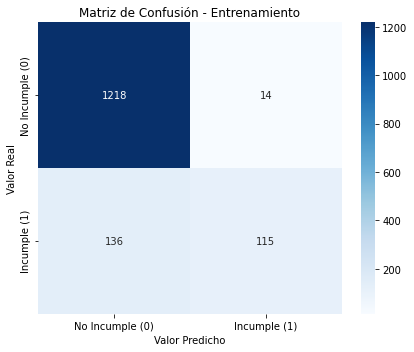

--- Evaluación para Evaluación ---
Accuracy:  0.8679
Precision: 0.6286
Recall:    0.3793
F1 Score:  0.4731


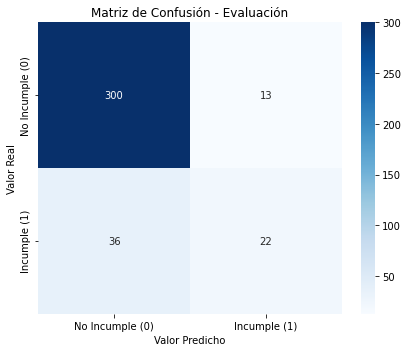

In [35]:
# 4. Evaluar el mejor modelo encontrado y visualizar sus métricas
best_model_tree = grid_tree.best_estimator_

acc_train_best_tree, prec_train_best_tree, rec_train_best_tree, f1_train_best_tree = evaluar(best_model_tree, X_train, y_train, "Entrenamiento")
acc_test_best_tree, prec_test_best_tree, rec_test_best_tree, f1_test_best_tree = evaluar(best_model_tree, X_test, y_test, "Evaluación")

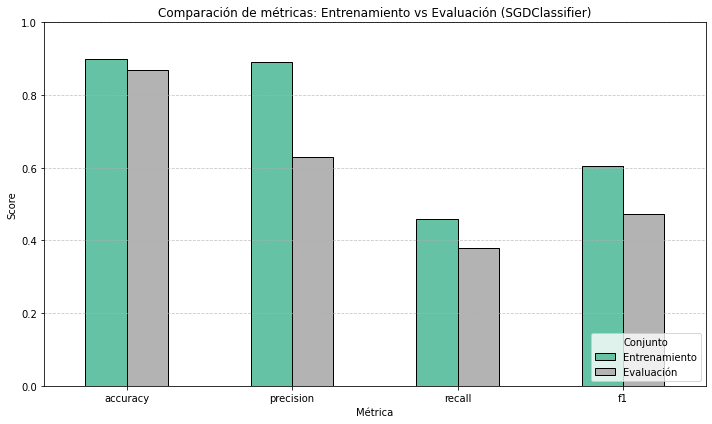

In [36]:
train_metrics_best_tree = [acc_train_best_tree, prec_train_best_tree, rec_train_best_tree, f1_train_best_tree]
test_metrics_best_tree = [acc_test_best_tree, prec_test_best_tree, rec_test_best_tree, f1_test_best_tree]
graficar_metricas_train_tesst(train_metrics_best_tree, test_metrics_best_tree)

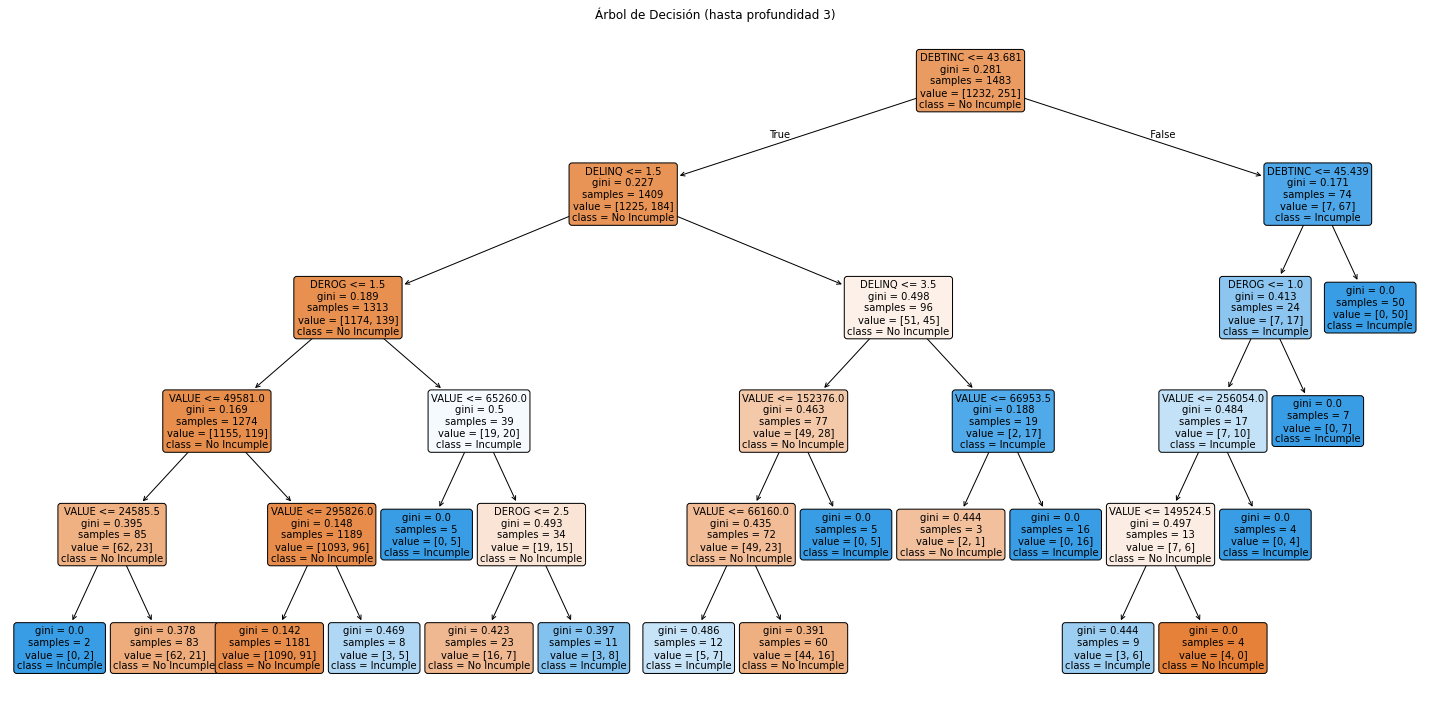

In [37]:
# Mostrar el árbol de decisión
visualizar_arbol_de_decision(best_model_tree)

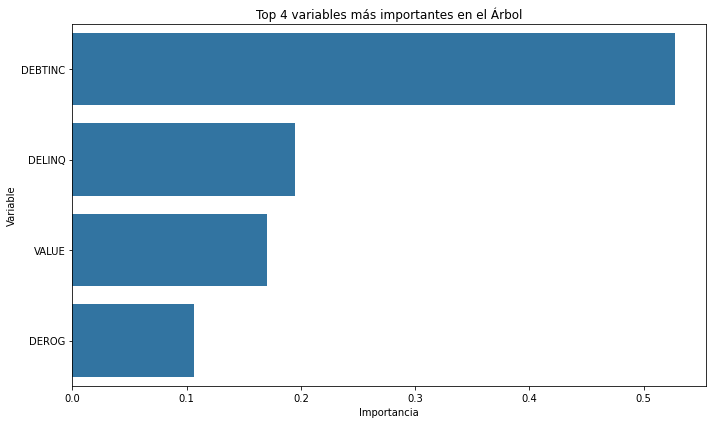

In [38]:
# Veamos la importancia de las variables predictoras

visualizar_variables_importantes(X, best_model_tree)

Podemos ver el impacto promedio de la variación de cada parámetro variado:

In [39]:
def rendimiento_por_parametro(parametro, results, nombre_parametro):
    # Agrupar resultados por parametro y calcular media y std del accuracy
    grouped = results.groupby(parametro).agg({
        'mean_test_score': 'mean',
        'std_test_score': 'mean'  # para simplificar, promedio de std
    }).reset_index()

    # Graficar
    plt.figure(figsize=(8, 5))
    plt.errorbar(
        x=grouped[parametro].astype(str),
        y=grouped['mean_test_score'],
        yerr=grouped['std_test_score'],
        fmt='o-', capsize=5, capthick=2
    )
    plt.title(f'Accuracy promedio vs. {nombre_parametro}')
    plt.xlabel(parametro)
    plt.ylabel('Accuracy promedio (CV)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


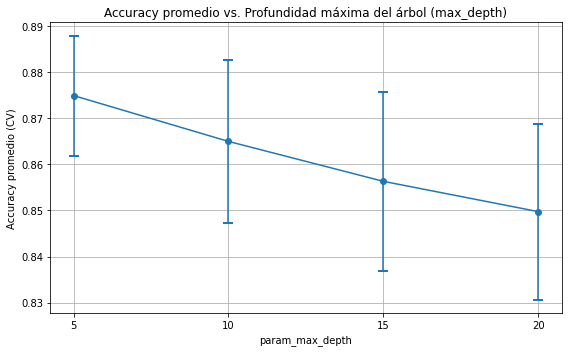

In [40]:
rendimiento_por_parametro('param_max_depth', results_tree, 'Profundidad máxima del árbol (max_depth)')

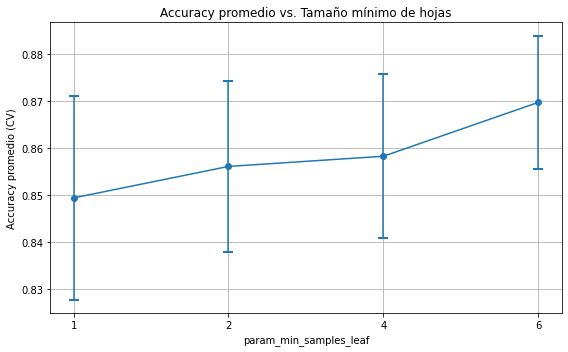

In [41]:
rendimiento_por_parametro('param_min_samples_leaf', results_tree, 'Tamaño mínimo de hojas')

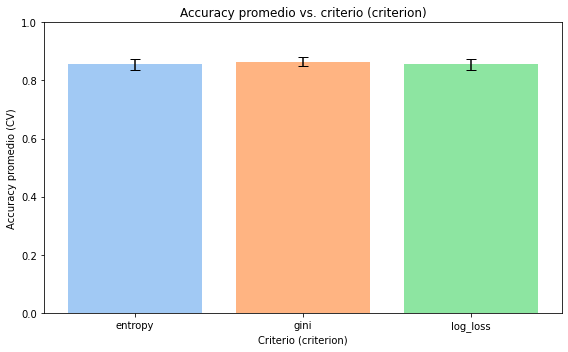

In [42]:
grouped_criterion = results_tree.groupby('param_criterion').agg({
    'mean_test_score': 'mean',
    'std_test_score': 'mean'
}).reset_index()

# Crear una figura con tamaño 8x5 pulgadas
plt.figure(figsize=(8, 5))

# Graficar un gráfico de barras:
# - Las barras están en las posiciones dadas por los valores únicos de 'param_criterion'
# - La altura de cada barra corresponde al accuracy promedio (mean_test_score)
# - Los colores se seleccionan del palette 'pastel' con tantos colores como categorías haya
plt.bar(
    x=grouped_criterion['param_criterion'],          # Posición de cada barra (categorías)
    height=grouped_criterion['mean_test_score'],     # Altura de barras (accuracy promedio)
    color=sns.color_palette('pastel', n_colors=len(grouped_criterion))  # Colores suaves
)

# Agregar barras de error (desviación estándar) usando errorbar:
# - 'x' es un arreglo numérico para las posiciones de las barras (0,1,2,...)
# - 'y' son las alturas de las barras (accuracy promedio)
# - 'yerr' es el error vertical (desviación estándar)
# - 'fmt' es 'none' para no dibujar puntos sobre las barras, solo error bars
# - 'ecolor' define el color de las barras de error (negro)
# - 'capsize' es el tamaño de las tapas de las barras de error
plt.errorbar(
    x=np.arange(len(grouped_criterion)),             # Posiciones numéricas para cada barra
    y=grouped_criterion['mean_test_score'],          # Alturas de barras (accuracy promedio)
    yerr=grouped_criterion['std_test_score'],        # Tamaño de error vertical (desviación estándar)
    fmt='none',                                      # No dibujar marcador, solo barras de error
    ecolor='black',                                  # Color negro para barras de error
    capsize=5                                        # Tamaño de las tapas en las barras de error
)

# Ajustar las etiquetas del eje x para mostrar el nombre de cada criterio (gini, entropy, etc)
plt.xticks(
    ticks=np.arange(len(grouped_criterion)),         # Posiciones numéricas de las barras
    labels=grouped_criterion['param_criterion']      # Etiquetas con los nombres de criterios
)

# Título del gráfico
plt.title('Accuracy promedio vs. criterio (criterion)')

# Etiqueta eje x
plt.xlabel('Criterio (criterion)')

# Etiqueta eje y
plt.ylabel('Accuracy promedio (CV)')

# Limitar eje y de 0 a 1 para mejor visualización de la precisión
plt.ylim(0, 1)

# Ajustar automáticamente el layout para que no haya elementos cortados
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### 🧠 Conclusión del Ejercicio 3.2 – Comparación antes y después del ajuste de hiperparámetros
Tras aplicar **GridSearchCV** para ajustar los hiperparámetros de `DecisionTreeClassifier`, se observaron mejoras en el desempeño (medidos con accuracy) en el conjunto de testeo, aunque el rendimiento en el conjunto de entrenamiento empeoró. Esto es esperable, porque el cross validation disminuye el overfitting del modelo, lo que empeora el rendimiento sobre el conjunto de entrenamiento, aunque mejora la capacidad para predecir sobre conjuntos no vistos antes por el modelo:

#### 📊 Mejora en métricas de evaluación:
| Métrica   |  Antes del ajuste | Después del ajuste |
|-----------|-------------------|--------------------|
| Accuracy  |  0.8356           | 0.8679             |
| Precision |  0.4769           | 0.6286             |
| Recall    |  0.5345           | 0.3793             |
| F1 Score  |  0.5041           | 0.4731             |


Respecto a las otras métricas, la búsqueda por grilla mejora significativamente la precisión (menos positivos), pero empeora significativamente el recall (Más falsos negativos, es decir, más morosos potenciales sin identificar). Debido al empeoramiento del recall, disminuyó también el f1-score.

### ✅ Conclusión final

Se observa un mejor desempeño con el modelo de árbol de decisión para este problema que con los modelos disponibles en `SGDClassifier`.